This is a R code 

This is a equation
$$
f(x)=\frac{1}{\sqrt{2\pi}\sigma}\mbox{exp}\left\{-\frac{(x-\mu)^2}{2\sigma^2}\right\}.
$$

Warning message:
"package 'ggplot2' was built under R version 4.3.2"
Warning message:
"package 'dplyr' was built under R version 4.3.2"
Warning message:
"package 'stringr' was built under R version 4.3.2"
Warning message:
"package 'lubridate' was built under R version 4.3.2"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'Bessel' was built under R version 4.3.3"


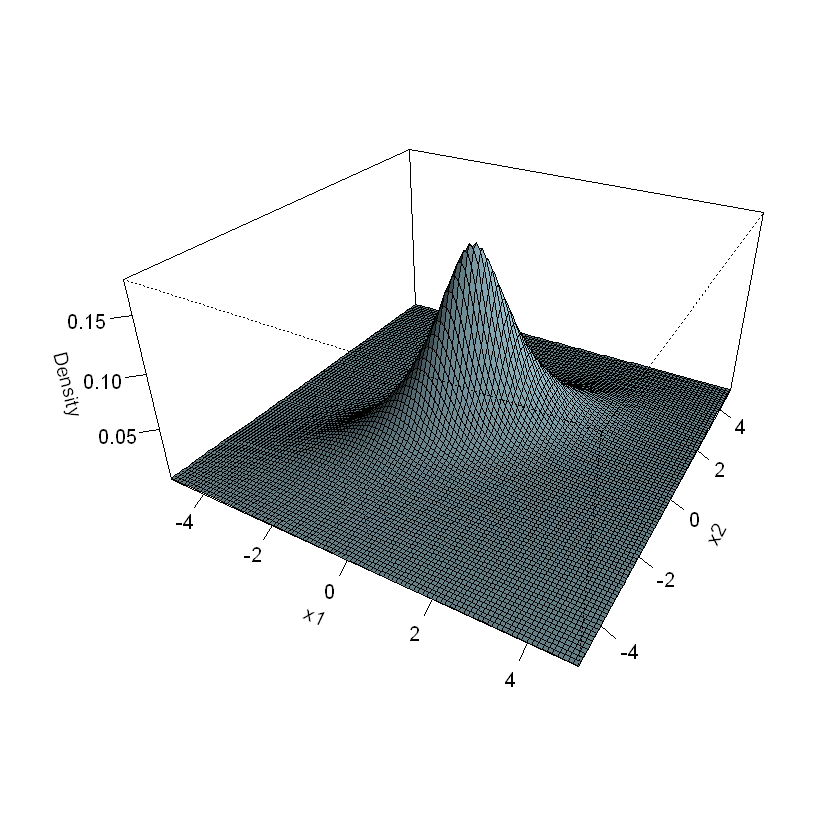

In [1]:
# 导入需要的Package
library(tidyverse)
library(Bessel)

# ==============================================================================================================================

# IG-N

# 两个维度x1和x2
x1 <- seq(-5, 5, length.out = 100)
x2 <- seq(-5, 5, length.out = 100)

# 设置参数
d <- 2
mu <- c(0, 0)
sigma <- matrix(c(2, 1.5, 1.5, 2), nrow = 2)
lambda <- 1.5

# 定义密度函数
f <- function(x1, x2) {
  x <- c(x1, x2)
  alpha <- t(x - mu) %*% solve(sigma) %*% (x - mu) * lambda + (lambda - 1)^2
  result <- sqrt(lambda) * exp(lambda - 1) / 2^((d-1)/2) / pi^((d+1)/2) / det(sigma)^(1/2) * besselK(sqrt(alpha), 0, expon = FALSE)
  return(result)
}

# 计算每个网格的密度
z <- matrix(nrow = 100, ncol = 100)
for (i in 1:100) {
  for (j in 1:100) {
    z[i, j] <- f(x1[i], x2[j])
  }
}

# 进行画图
persp(x1, x2, z, theta = 30, phi = 30, expand = 0.5, col = "lightblue",
      ltheta = 120, shade = 0.75, ticktype = "detailed",
      xlab = "x1", ylab = "x2", zlab = "Density")

In [12]:
# 开始计时
start_time <- Sys.time()

# 导入需要的Package
suppressMessages(suppressWarnings(library(tidyverse)))
suppressWarnings(suppressMessages(library(Runuran)))
suppressWarnings(suppressMessages(library(mvtnorm)))
suppressWarnings(suppressMessages(library(e1071)))
suppressWarnings(suppressMessages(library(Bessel)))
  
  # 生成随机数
  rMGeN <- function(n, Mu, Sigma, Lambda) {
    
    # 生成τ分布的随机数
    distr <- udig(mu = Lambda / (Lambda - 1), lambda = Lambda)
    gen <- pinvd.new(distr)
    tau <- ur(gen, n)
    
    # 随机表示方法生称多元GeN分布随机数
    z <- rmvnorm(n, rep(0, nrow(Sigma)), Sigma)
    x <- matrix(rep(Mu,n), nrow = n, byrow = TRUE) + z / sqrt(tau)
    return(x)
  }
  
  # 定义对数似然函数
  log_f1 <- function(X, mu, sigma, lambda) {
    d <- length(mu)
    f <- function(x) {
      alpha <- t(x - mu) %*% solve(sigma) %*% (x - mu) * lambda + (lambda - 1)^2
      result <- sqrt(lambda) * exp(lambda - 1) / 2^((d-1)/2) / pi^((d+1)/2) / det(sigma)^(1/2) * besselK(sqrt(alpha), 0, expo = FALSE)
      return(result)
    }
    pdf <- apply(X, 2, f)
    return(sum(log(pdf)))
  }
  
  # 无协变量的NEM算法
  NEM <- function(mu, sigma, lambda, X, ep = 1e-4) {
    index <- 0
    k <- 0
    
    n <- ncol(X)
    d <- nrow(X)
    
    f1 <- function(X, mu, sigma, lambda) {
      
      compute.alpha <- function(x) {
        return(t(x - mu) %*% solve(sigma) %*% (x - mu) + (lambda - 1)^2 / lambda)
      }
      alpha <- apply(X, 2, compute.alpha)
      beta <- lambda
      
      result1 <- BesselK(sqrt(alpha * beta), 1, expo = TRUE) / BesselK(sqrt(alpha * beta), 0, expo = TRUE) * (beta / alpha)^0.5
      result2 <- BesselK(sqrt(alpha * beta), -1, expo = TRUE) / BesselK(sqrt(alpha * beta), 0, expo = TRUE) * (beta / alpha)^(-0.5)
      return(cbind(result1, result2))
    }
    
    v1 <- rep(1, n)
    
    mu_new <- mu
    sigma_new <- sigma
    lambda_new <- lambda
    
    while (k <= 1000) {
      mu <- mu_new
      sigma <- sigma_new
      lambda <- lambda_new
      
      loglikeli <- log_f1(X, mu, sigma, lambda)
      
      a1 <- f1(X, mu, sigma, lambda)[, 1]
      mu_new <- X %*% a1 / sum(a1)
      cat("Mu:", mu_new, "\n")
      A1 <- diag(a1)
      sigma_new <- (X - mu_new %*% v1) %*% A1 %*% t(X - mu_new %*% v1) / n
      cat("Sigma:", sigma_new, "\n")
      Ba1 <- mean(a1)
      Bd1 <- mean(f1(X, mu, sigma, lambda)[,2])
      lambda_new <- (-1-sqrt(1-4*Ba1*(2-Ba1-Bd1))) / (2*(2-Ba1-Bd1))
      cat("Lambda:", lambda_new, "\n")
      
      loglikeli_new <- log_f1(X, mu_new, sigma_new, lambda_new)
      cat("Loglikelihood:", loglikeli_new, "\n")
      
      if (abs((loglikeli_new - loglikeli) / loglikeli) < ep) {
        index <- 1
        break
      }
      cat("Iteration number:", k, "\n")
      k <- k + 1
    }
    
    result <- list(Mu = mu_new, 
                   Sigma = sigma_new, 
                   Lambda = lambda_new, 
                   Kurtosis = 3 * (lambda_new + 1) / lambda_new^2, 
                   Loglikelihood = loglikeli_new,
                   number = k, 
                   index = index)
    return(result)
  }

# 设定参数
size <- 1000
Mu <- c(0, 0)
Sigma <- matrix(c(1, 0.5, 0.5, 1), nrow = 2)
Lambda <- 4
Kurtosis <- 3 * (Lambda + 1) / Lambda^2


    x <- rMGeN(size, Mu, Sigma, Lambda)
    
    # 矩估计确定初值
    m <- colMeans(x)
    s <- var(x)
    kur <- apply(x, 2, kurtosis, type = 1) %>% mean()
    l <- (3+sqrt(12*kur+9)) / (2*kur)
    
    
    Res <- tryCatch({
      NEM(m, s, l, t(x))
    }, error = function(e) {
      NA
    }, warning = function(w) {
      NA
    })
# 结束运算，输出时间
end_time <- Sys.time()
print(end_time - start_time)

Mu: -0.07808989 -0.03674674 
Sigma: 0.9135427 0.4288479 0.4288479 0.893794 
Lambda: 4.670878 
Loglikelihood: -2707.871 
Iteration number: 0 
Mu: -0.07801751 -0.03566557 
Sigma: 0.8936803 0.4199245 0.4199245 0.873354 
Lambda: 4.886165 
Loglikelihood: -2706.191 
Iteration number: 1 
Mu: -0.07799918 -0.03564559 
Sigma: 0.8902276 0.4182899 0.4182899 0.8699689 
Lambda: 5.085196 
Loglikelihood: -2705.105 
Iteration number: 2 
Mu: -0.07799196 -0.03582277 
Sigma: 0.8911036 0.4186191 0.4186191 0.8710006 
Lambda: 5.275255 
Loglikelihood: -2704.194 
Iteration number: 3 
Mu: -0.07798838 -0.03602528 
Sigma: 0.8929956 0.4194177 0.4194177 0.8730522 
Lambda: 5.458815 
Loglikelihood: -2703.404 
Iteration number: 4 
Mu: -0.07798682 -0.03621896 
Sigma: 0.8950228 0.4202838 0.4202838 0.8752303 
Lambda: 5.636765 
Loglikelihood: -2702.714 
Iteration number: 5 
Mu: -0.07798665 -0.03639812 
Sigma: 0.8969681 0.4211173 0.4211173 0.8773169 
Lambda: 5.809524 
Loglikelihood: -2702.107 
Iteration number: 6 
Mu: -0.0